#  Visual Sicilian

###  Eryk Wdowiak

This notebook attempts to illustrate the Sicilian text that we're using to develop a neural machine translator.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.collocations import *

# import string
# import re

from wordcloud import WordCloud

In [3]:
import mxnet as mx
from mxnet import gluon
from mxnet import nd
import gluonnlp as nlp

from data import transform_data_word2vec, preprocess_dataset
from model import SG, CBOW
from utils import print_time

context = mx.cpu()

In [4]:
##  on the Sicilian side, this function only runs NLTK tokenizer
##  on the English side, it will do much more
def process_line(line):
    tokens = word_tokenize(line)
    return tokens

In [5]:
##  read in the lemmatized data
df = pd.read_csv('dataset/train-mparamu_v2-lemmatized.sc',header=None)
df.columns = ['sc_text']
# df.head()

###  frequencies

In [6]:
##  flatten data to count words
proc_scn = list(map(process_line, df.sc_text))
flat_scn = [item for sublist in proc_scn for item in sublist]
freq_scn = FreqDist(flat_scn)

In [7]:
freq_scn.most_common(10)

[('essiri', 4731),
 ('nun', 2409),
 ('aviri', 2259),
 ('fari', 1268),
 ('vuliri', 876),
 ('sicilianu', 845),
 ('chiu', 704),
 ('putiri', 671),
 ('diri', 657),
 ('quannu', 574)]

### counts

In [8]:
# create counts
scn_bar_words = [x[0] for x in freq_scn.most_common(25)]
scn_bar_counts = [x[1] for x in freq_scn.most_common(25)]

# put data into dictionary
scn_dict = dict(zip(scn_bar_words, scn_bar_counts))

In [9]:
# set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

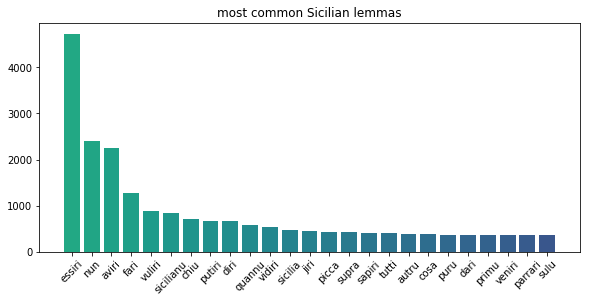

In [10]:
fig, axs = plt.subplots(figsize=(8,4))

axs.bar(scn_bar_words, scn_bar_counts , color=color)
axs.title.set_text('most common Sicilian lemmas')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.tight_layout(pad=0)

plt.savefig('wb-sc_lemmas.png')
plt.show()

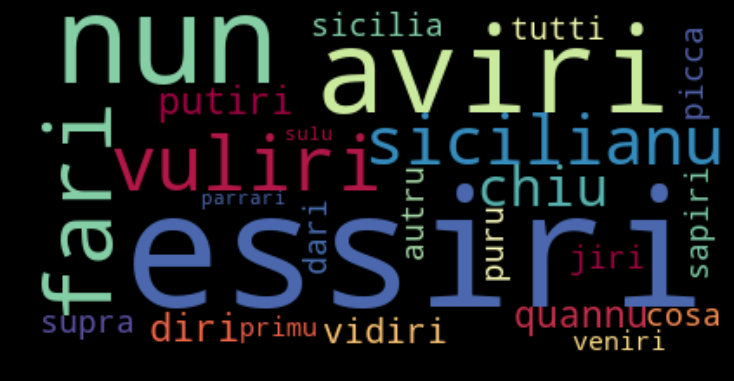

In [11]:
# create cloud of Sicilian words by frequency
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(scn_dict)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.savefig('wb-sc_lemma-cloud.png')
plt.show()

### make wordcloud from embeddings

In [12]:
##  load datafile (so that we can retrieve vocabulary)
datafile = 'dataset/train-mparamu_v3-lemmatized.sc.tsv'

##  CBOW model
# model = CBOW
# parmfile = './logs/sc-cbow-r4-e01.params'
# fname_insert = 'cbow'

##  skipgram model
model = SG
parmfile = './logs/sc-skip-r2-e23.params'
fname_insert = 'skip'

##  both trained with hyperparameters:
output_dim = 300
batch_size = 128

In [13]:
##  load the data
data = nlp.data.TSVDataset(datafile)
data, vocab, idx_to_counts = preprocess_dataset( data ) 

##  load the model
embedding = model(token_to_idx=vocab.token_to_idx, output_dim=output_dim,
                  batch_size=batch_size, #num_negatives=num_negatives,
                  negatives_weights=mx.nd.array(idx_to_counts))
embedding.load_parameters(parmfile)

##  get the word vectors
wvecs = embedding.embedding_out.weight.data()

##  count words with at least "min_words" appearances
min_words = 10
num_over_min = len( np.array(idx_to_counts)[ np.array(idx_to_counts)>= min_words ] )

print('vocabulary length:    ' + str(len(vocab)))
print('lemmas over ' + str(min_words) + ' times: ' + str(num_over_min))

vocabulary length:    2776
lemmas over 10 times: 1413


In [14]:
##  pairwise cosine similarity
def cos_sim(wordx, wordy):
    xx = wvecs[vocab.token_to_idx[wordx],]
    yy = wvecs[vocab.token_to_idx[wordy],]
    return nd.dot(xx, yy) / (nd.norm(xx) * nd.norm(yy))

##  full matrix of cosine similarity
def cos_mat( vecs ):
    ##  dot product divided by the norms
    xtx = nd.dot( vecs , vecs.T)
    nmx = nd.sqrt( nd.diag(xtx) ).reshape((-1,1))
    cnm = nd.dot( nmx , nmx.T )
    return xtx / cnm

In [15]:
##  create "WC Dict" ("word-to-cosine dictionary") for wordcloud
def mk_wcdict(word,k_words):
    
    ##  where to start?  first two tokens are: <BOS> <EOS>
    sv_start = 2
    
    ##  get cosine matrix
    cosmat = cos_mat( wvecs[sv_start:-1,] )
    
    ##  get the row of cosines
    idx_to_lookup = vocab.token_to_idx[word] - sv_start
    row_looked_up = cosmat[idx_to_lookup,]
    
    ##  nearest neighbors by cosine similarity
    knn_cosmat = row_looked_up.argsort()[::-1][1:k_words+1].astype(int).asnumpy()
    
    ##  indexes of nearest neighbors in vocab list
    knn_vocab_idx = list(knn_cosmat + sv_start)
    
    ##  get the words and cosine measures
    knn_vocab_words = [vocab.idx_to_token[idx] for idx in knn_vocab_idx]
    knn_vocab_cosines = [cosmat[idx_to_lookup,idx].asnumpy()[0] for idx in knn_cosmat]
        
    ##  return the dictionary for wordcloud
    return dict(zip(knn_vocab_words,knn_vocab_cosines))

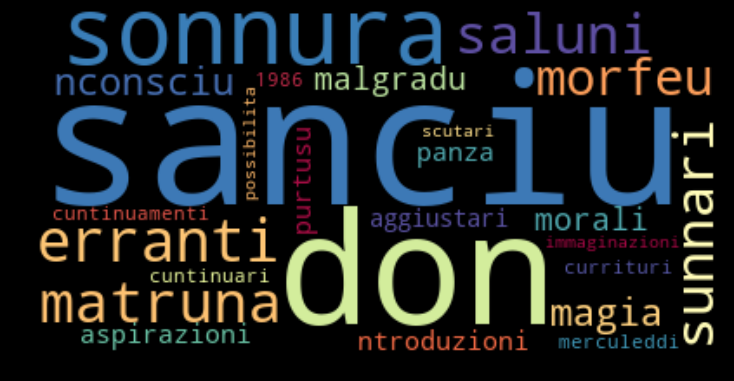

In [16]:
# create a cloud of 25 words for Don Chisciotti!
knn_wc_dict = mk_wcdict('chisciotti',25)
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(knn_wc_dict)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

fname = 'wc-sc-' + fname_insert + '_chisciotti.png'
plt.savefig(fname)
plt.show()

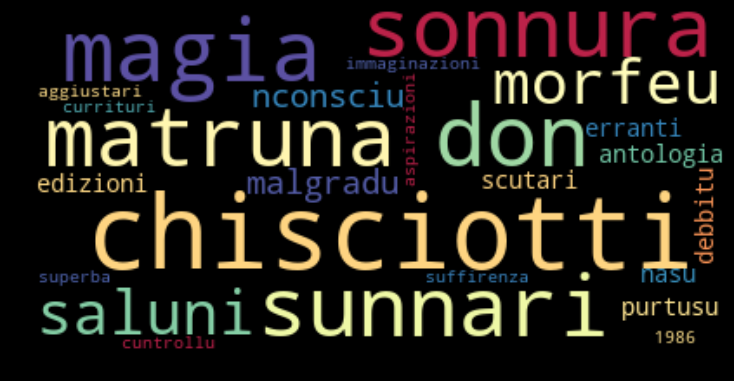

In [17]:
# create a cloud of 25 words for Sanciu Panza!
knn_wc_dict = mk_wcdict('sanciu',25)
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(knn_wc_dict)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

fname = 'wc-sc-' + fname_insert + '_sanciu.png'
plt.savefig(fname)
plt.show()

### bigrams and trigrams

In [18]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [19]:
scn_bi_finder = BigramCollocationFinder.from_words(flat_scn)
# scn_bi_finder.apply_freq_filter(5)
scn_bi_scored = scn_bi_finder.score_ngrams(bigram_measures.raw_freq)
scn_bi_scored[:10]

[(('nun', 'essiri'), 0.0036933723405289296),
 (('nun', 'aviri'), 0.0023229368141747743),
 (('nun', 'putiri'), 0.0018952831747451088),
 (('nun', 'vuliri'), 0.0015356653415883445),
 (('nun', 'sapiri'), 0.0011371699048470653),
 (('aviri', 'essiri'), 0.0010594146976780352),
 (('no', 'nun'), 0.0009525012878206187),
 (('essiri', 'chiu'), 0.0009233430851322324),
 (('sicilianu', 'essiri'), 0.0008844654815477174),
 (('nun', 'fari'), 0.0007581132698980435)]

In [20]:
scn_bi_pmi_finder = BigramCollocationFinder.from_words(flat_scn)
scn_bi_pmi_finder.apply_freq_filter(5)
scn_bi_pmi_scored = scn_bi_pmi_finder.score_ngrams(bigram_measures.pmi)
scn_bi_pmi_scored[0:10]

[(('delle', 'vigne'), 14.32877308558744),
 (('pier', 'delle'), 14.32877308558744),
 (('abbazia', 'thelema'), 14.065738679753643),
 (('von', 'gloeden'), 13.480776179032485),
 (('vittoriu', 'emanueli'), 13.1912695618375),
 (('giardini', 'naxos'), 13.106380664250988),
 (('gioveddi', 'venerdi'), 12.895813678311331),
 (('nino', 'provenzano'), 12.731837943200201),
 (('jim', 'brucia'), 12.650701180474801),
 (('francesco', 'lanzari'), 12.563238339224462)]

In [21]:
scn_tri_finder = TrigramCollocationFinder.from_words(flat_scn)
# scn_tri_finder.apply_freq_filter(5)
scn_tri_scored = scn_tri_finder.score_ngrams(trigram_measures.raw_freq)
scn_tri_scored[:10]

[(('no', 'nun', 'vuliri'), 0.0005151282474948244),
 (('vuliri', 'mparari', 'sicilianu'), 0.00024298502240321907),
 (('nun', 'essiri', 'chiu'), 0.00016522981523418897),
 (('nun', 'aviri', 'mai'), 0.00014579101344193145),
 (('nun', 'aviri', 'nenti'), 0.0001360716125458027),
 (('no', 'ancora', 'nun'), 0.0001263522116496739),
 (('nun', 'essiri', 'nenti'), 0.0001263522116496739),
 (('sicilianu', 'essiri', 'vuliri'), 0.0001263522116496739),
 (('sicilianu', 'no', 'nun'), 0.0001263522116496739),
 (('vuliri', 'parrari', 'sicilianu'), 0.0001263522116496739)]

In [22]:
scn_tri_pmi_finder = TrigramCollocationFinder.from_words(flat_scn)
scn_tri_pmi_finder.apply_freq_filter(5)
scn_tri_pmi_scored = scn_tri_pmi_finder.score_ngrams(trigram_measures.pmi)
scn_tri_pmi_scored[0:10]

[(('pier', 'delle', 'vigne'), 28.657546171174868),
 (('secunna', 'guerra', 'mundiali'), 22.468512346784863),
 (('giuseppe', 'tomasi', 'lampedusa'), 22.217923033617758),
 (('rosina', 'san', 'paolo'), 22.09194899532065),
 (('cumpunenti', 'assemblea', 'reggionali'), 20.195722973685875),
 (('chisciotti', 'sanciu', 'panza'), 20.003421645946325),
 (('sunnari', 'occhiu', 'aperti'), 19.2871825820703),
 (('via', 'roma', 'scusari'), 19.241382006441746),
 (('cappiddazzu', 'pagari', 'tuttu'), 18.825415670078947),
 (('aspittari', 'cincu', 'minuti'), 18.077144377834955)]